- 比赛题目：学术论文分类挑战赛
- 比赛链接：http://challenge.xfyun.cn/topic/info?type=academic-paper-classification
- 比赛任务：本次赛题希望参赛选手利用论文信息：论文id、标题、摘要，划分论文具体类别。

## 1 导入包

In [ ]:
!pip install simpletransformers -i https://pypi.tuna.tsinghua.edu.cn/simple

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
import gc
import os
import torch
from sklearn.model_selection import StratifiedKFold
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 设置显卡
# 配置
%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 25, 20
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## 2 加载数据

In [3]:
train = pd.read_csv('data/train/train.csv', sep='\t')
test = pd.read_csv('data/test/test.csv', sep='\t')
sub = pd.read_csv('data/sample_submit.csv')

In [4]:
train.head(5)

,paperid,title,abstract,categories
0,train_00000,"Hard but Robust, Easy but Sensitive: How Encod...",Neural machine translation (NMT) typically a...,cs.CL
1,train_00001,An Easy-to-use Real-world Multi-objective Opti...,Although synthetic test problems are widely ...,cs.NE
2,train_00002,Exploration of reproducibility issues in scien...,This is the first part of a small-scale expl...,cs.DL
3,train_00003,Scheduled Sampling for Transformers,Scheduled sampling is a technique for avoidi...,cs.CL
4,train_00004,Hybrid Forests for Left Ventricle Segmentation...,Machine learning models produce state-of-the...,cs.CV


In [5]:
# 数据大小
train.shape,test.shape,sub.shape

((50000, 4), (10000, 3), (10000, 2))

### 2.1 查看缺失值

In [6]:
# 查看是否有缺失值
train.isnull().sum()

paperid       0
title         0
abstract      0
categories    0
dtype: int64

In [7]:
test.isnull().sum()

paperid     0
title       0
abstract    0
dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paperid     50000 non-null  object
 1   title       50000 non-null  object
 2   abstract    50000 non-null  object
 3   categories  50000 non-null  object
dtypes: object(4)
memory usage: 1.5+ MB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   paperid   10000 non-null  object
 1   title     10000 non-null  object
 2   abstract  10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [10]:
print("train null nums")
print(train.shape[0]-train.count())
print("test null nums")
print(test.shape[0]-test.count())

train null nums
paperid       0
title         0
abstract      0
categories    0
dtype: int64
test null nums
paperid     0
title       0
abstract    0
dtype: int64


### 2.2 标签分布

In [11]:
train['categories'].value_counts()

cs.CV    11038
cs.CL     4260
cs.NI     3218
cs.CR     2798
cs.AI     2706
cs.DS     2509
cs.DC     1994
cs.SE     1940
cs.RO     1884
cs.LO     1741
cs.LG     1352
cs.SY     1292
cs.CY     1228
cs.DB      998
cs.GT      984
cs.HC      943
cs.PL      841
cs.IR      770
cs.CC      719
cs.NE      704
cs.CG      683
cs.OH      677
cs.SI      603
cs.DL      537
cs.DM      523
cs.FL      469
cs.AR      363
cs.CE      362
cs.GR      314
cs.MM      261
cs.ET      230
cs.MA      210
cs.NA      176
cs.SC      172
cs.SD      140
cs.PF      139
cs.MS      105
cs.OS       99
cs.GL       18
Name: categories, dtype: int64

Text(0.5, 0, 'categories count')

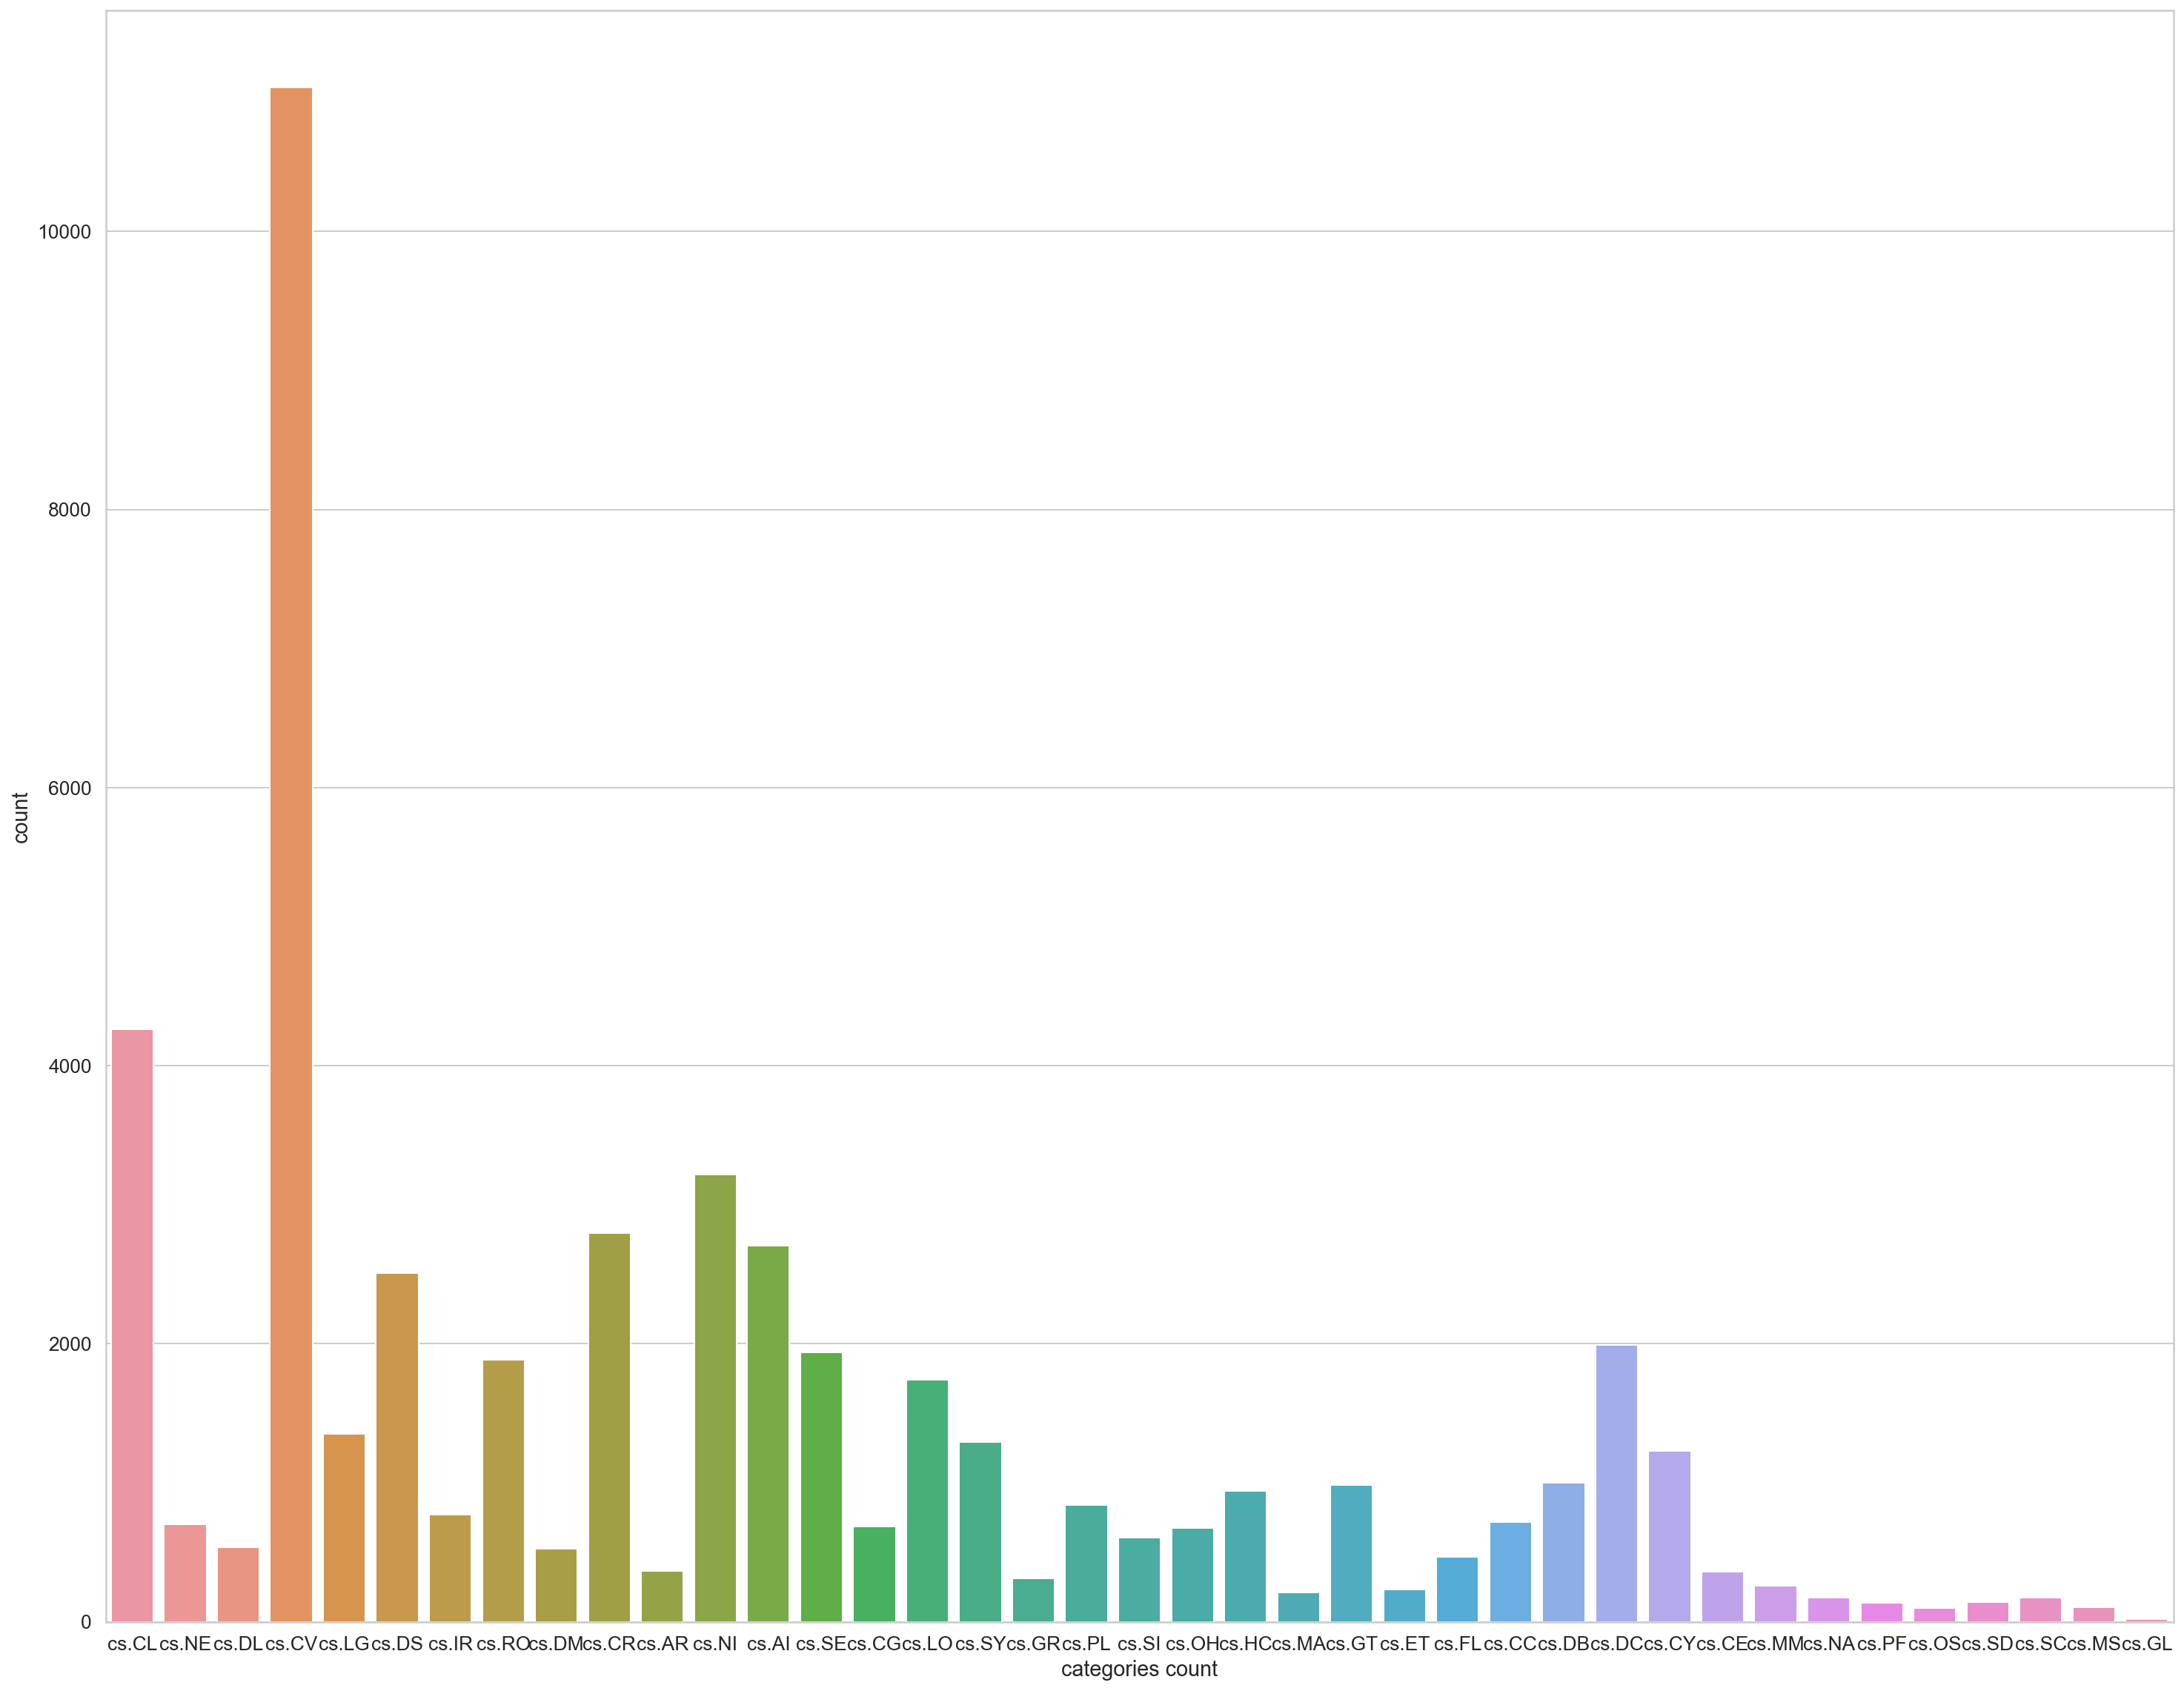

In [12]:
sns.countplot(train.categories)
plt.xlabel('categories count')

## 3 数据预处理

In [13]:
# 拼接title与abstract
train['text']=train['title']+' '+train['abstract']
test['text']=test['title']+' '+test['abstract']

### 3.1 文本长度分布

In [14]:
train['text_len']=train['text'].map(len)

In [15]:
train['text'].map(len).describe()

count    50000.00000
mean      1131.28478
std        387.14365
min         69.00000
25%        860.00000
50%       1117.00000
75%       1393.00000
max       3713.00000
Name: text, dtype: float64

In [16]:
test['text'].map(len).describe()

count    10000.000000
mean      1127.097700
std        388.662603
min         74.000000
25%        855.750000
50%       1111.000000
75%       1385.250000
max       3501.000000
Name: text, dtype: float64

<AxesSubplot:ylabel='Density'>

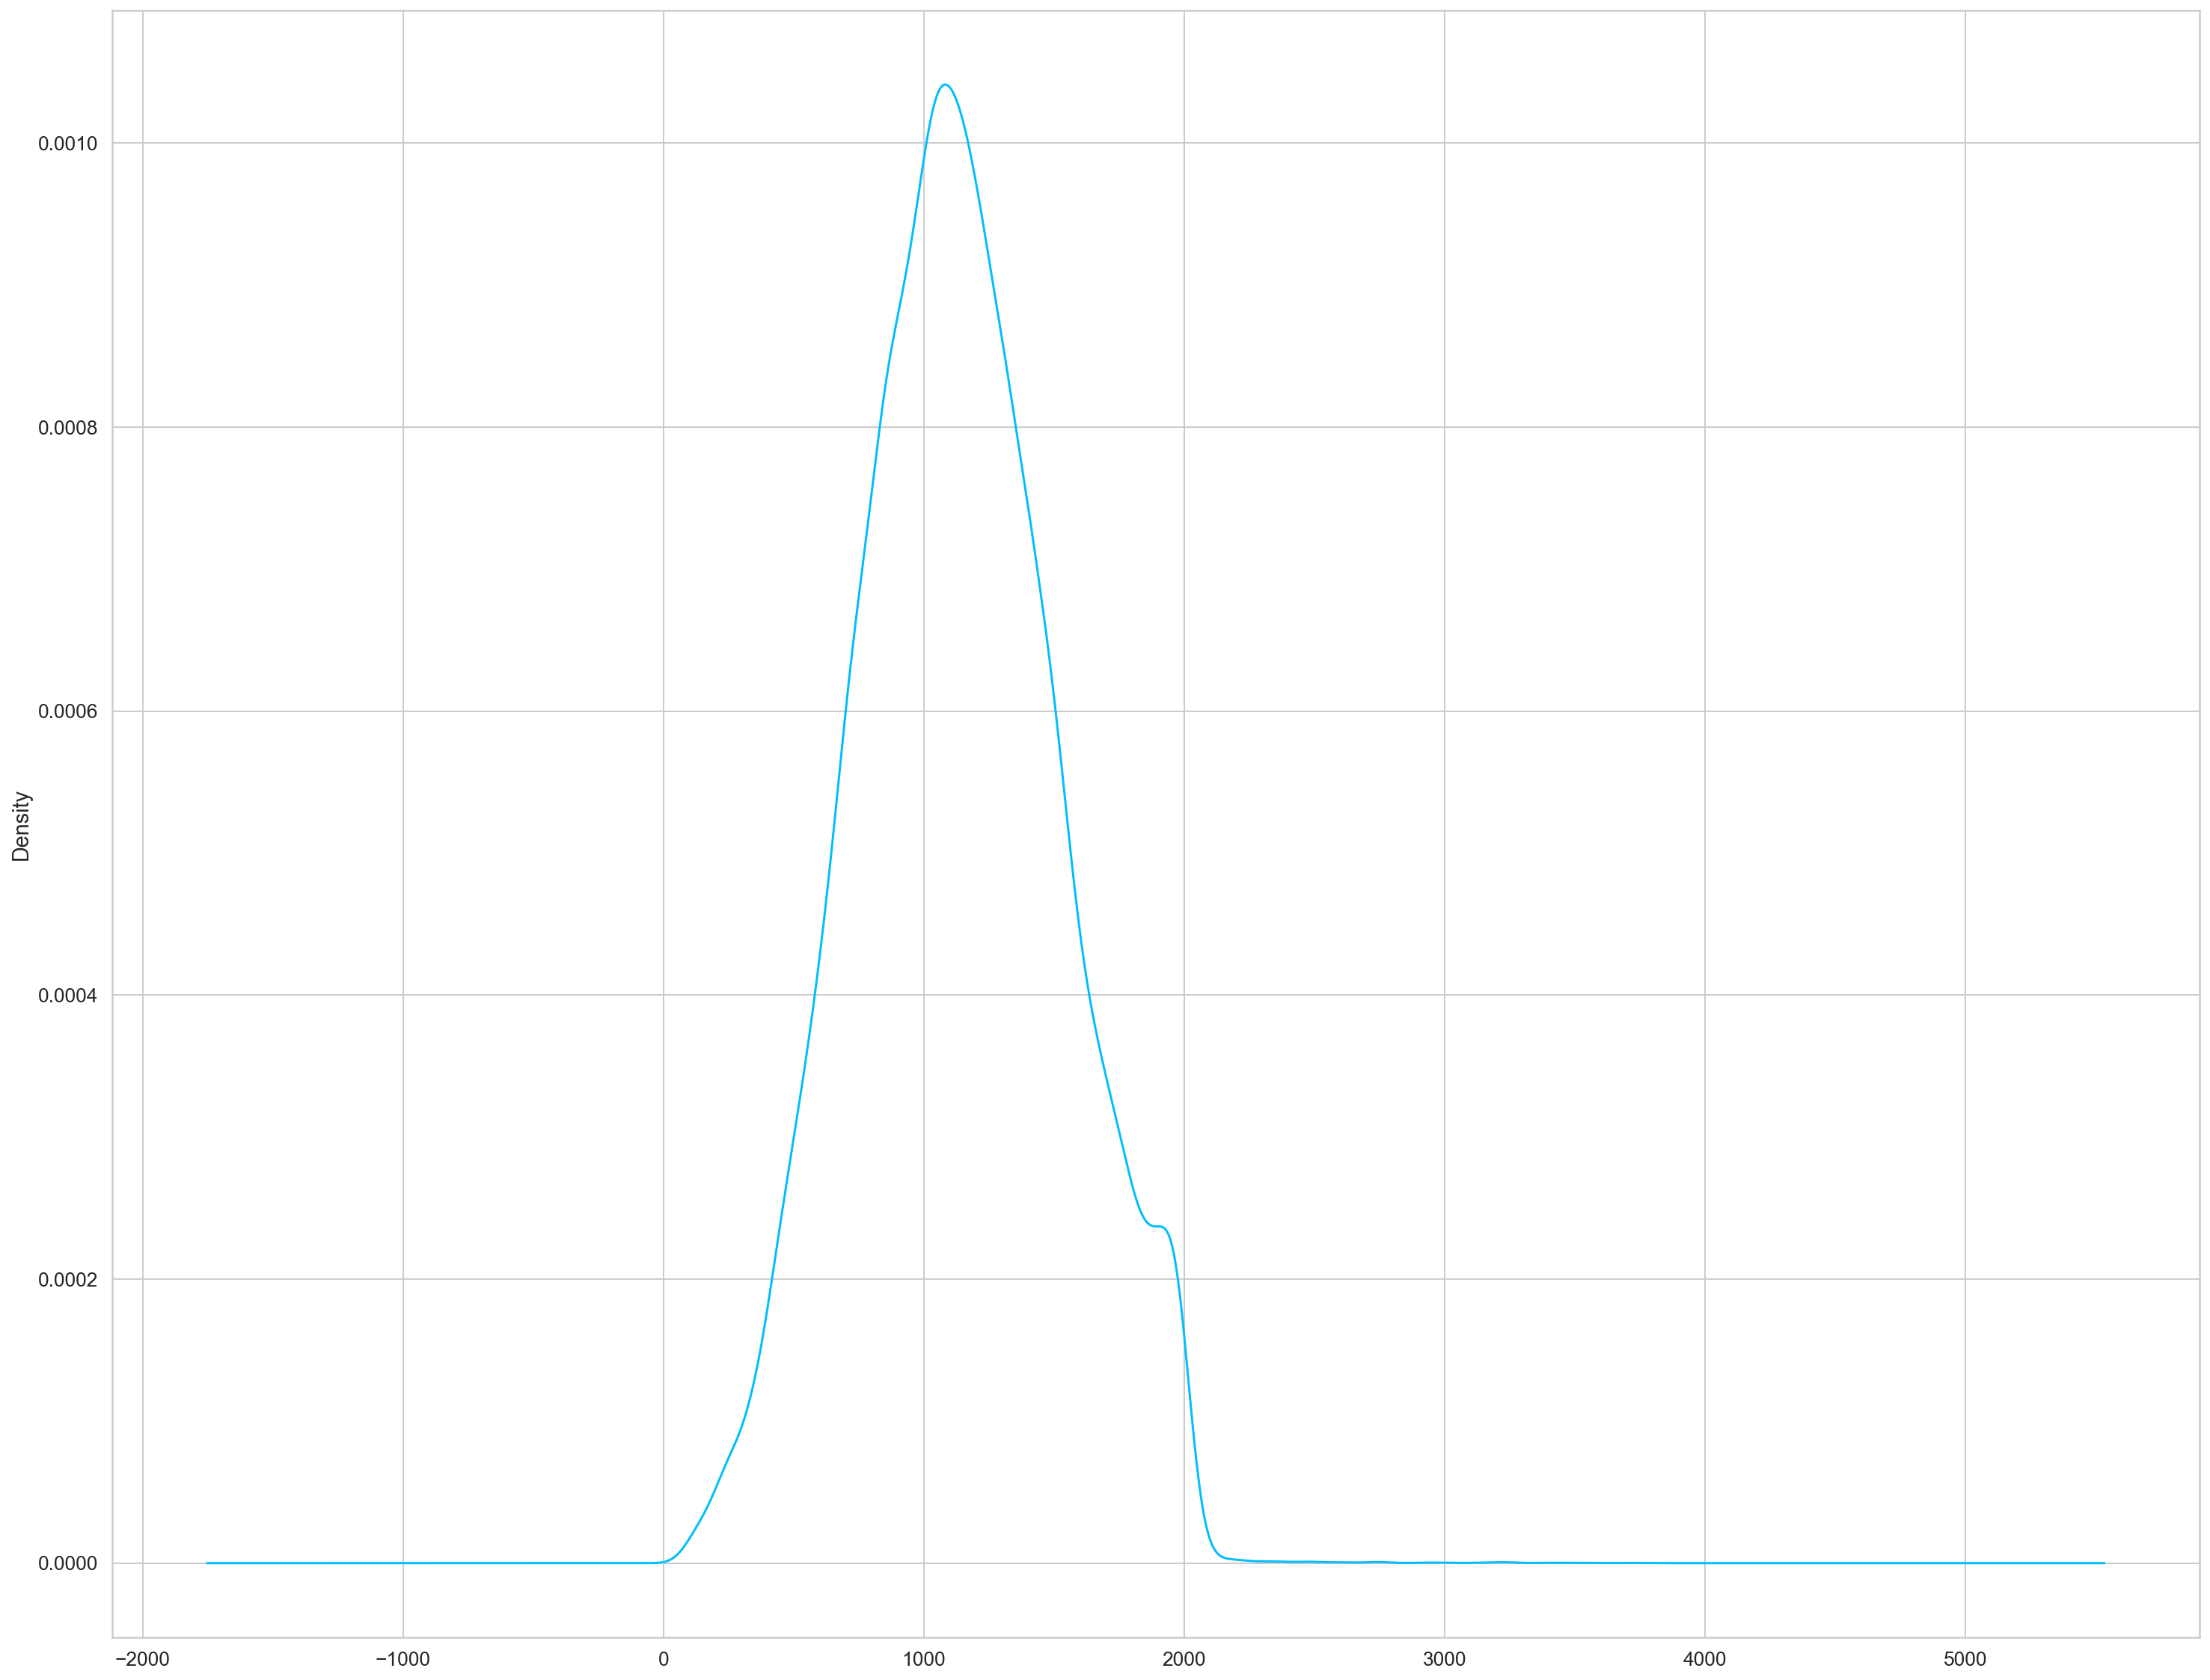

In [17]:
train['text_len'].plot(kind='kde')

## 标签与唯一标签映射

In [18]:
label_id2cate=dict(enumerate(train.categories.unique()))
label_cate2id={value: key for key,value in label_id2cate.items()}

In [19]:
label_id2cate

{0: 'cs.CL',
 1: 'cs.NE',
 2: 'cs.DL',
 3: 'cs.CV',
 4: 'cs.LG',
 5: 'cs.DS',
 6: 'cs.IR',
 7: 'cs.RO',
 8: 'cs.DM',
 9: 'cs.CR',
 10: 'cs.AR',
 11: 'cs.NI',
 12: 'cs.AI',
 13: 'cs.SE',
 14: 'cs.CG',
 15: 'cs.LO',
 16: 'cs.SY',
 17: 'cs.GR',
 18: 'cs.PL',
 19: 'cs.SI',
 20: 'cs.OH',
 21: 'cs.HC',
 22: 'cs.MA',
 23: 'cs.GT',
 24: 'cs.ET',
 25: 'cs.FL',
 26: 'cs.CC',
 27: 'cs.DB',
 28: 'cs.DC',
 29: 'cs.CY',
 30: 'cs.CE',
 31: 'cs.MM',
 32: 'cs.NA',
 33: 'cs.PF',
 34: 'cs.OS',
 35: 'cs.SD',
 36: 'cs.SC',
 37: 'cs.MS',
 38: 'cs.GL'}

In [20]:
label_cate2id

{'cs.CL': 0,
 'cs.NE': 1,
 'cs.DL': 2,
 'cs.CV': 3,
 'cs.LG': 4,
 'cs.DS': 5,
 'cs.IR': 6,
 'cs.RO': 7,
 'cs.DM': 8,
 'cs.CR': 9,
 'cs.AR': 10,
 'cs.NI': 11,
 'cs.AI': 12,
 'cs.SE': 13,
 'cs.CG': 14,
 'cs.LO': 15,
 'cs.SY': 16,
 'cs.GR': 17,
 'cs.PL': 18,
 'cs.SI': 19,
 'cs.OH': 20,
 'cs.HC': 21,
 'cs.MA': 22,
 'cs.GT': 23,
 'cs.ET': 24,
 'cs.FL': 25,
 'cs.CC': 26,
 'cs.DB': 27,
 'cs.DC': 28,
 'cs.CY': 29,
 'cs.CE': 30,
 'cs.MM': 31,
 'cs.NA': 32,
 'cs.PF': 33,
 'cs.OS': 34,
 'cs.SD': 35,
 'cs.SC': 36,
 'cs.MS': 37,
 'cs.GL': 38}

In [21]:
train['label']=train['categories'].map(label_cate2id)

## 4  模型训练与评估

In [22]:
train=train[['text','label']]
train_y=train["label"]

In [23]:
train_df=train[['text','label']][:45000]
eval_df=train[['text','label']][45000:]
train_df.shape,eval_df.shape

((45000, 2), (5000, 2))

### 4.1 模型训练

In [27]:
model_args = ClassificationArgs()
model_args.max_seq_length = 512
model_args.train_batch_size = 8
model_args.num_train_epochs = 5
model_args.fp16 = False
model_args.evaluate_during_training = False
model_args.overwrite_output_dir = True

model_type = 'roberta'
model_name = 'roberta-base'
print("training {}.........".format(model_name))
model_args.cache_dir = './caches' + '/' + model_name.split('/')[-1]
model_args.output_dir = './outputs' + '/' + model_name.split('/')[-1]

model = ClassificationModel(
    model_type,
    model_name,
    num_labels=39,
    args=model_args)

model.train_model(train_df, eval_df=eval_df)
result, _, _ = model.eval_model(eval_df, acc=accuracy_score)
print(result)



training roberta-base.........


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.de


{'mcc': 0.6061955662242928, 'acc': 0.6392, 'eval_loss': 1.335857630133629}


### 4.2 模型评估

In [28]:
data = []
for index, row in test.iterrows():
    data.append(str(row['text']))
predictions, raw_outputs = model.predict(data)
sub = pd.read_csv('data/sample_submit.csv')
sub['categories'] = predictions
sub['categories'] = sub['categories'].map(label_id2cate)
sub.to_csv('result/submit_{}.csv'.format(model_name), index=False)
del model
gc.collect()

69